In [1]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')

base_path = r"gdrive/MyDrive/Colab_Notebooks/DeepQL/"

data_path = base_path + r"data/"
model_path = base_path + r"model/"

# allows to import python files easily
sys.path.append(base_path)

Mounted at /content/gdrive


In [2]:
# models available
# write a name of the model to the model_file_name
!cd $model_path && ls

040223.pt		   song_040223_epoch14.pt  song_0403_epoch49.pt
song_040223_best_ep_25.pt  song_040223_epoch9.pt   song_0403_epoch99.pt
song_040223_best_fit.pt    song_0403_batch1_29.pt  song_0403_epoch9.pt
song_040223_epoch10.pt	   song_0403_epoch10.pt    song_0403_part_2_49.pt



# Loading model and continuum training

In [8]:
from diffnet import F_function, W_matrix, diffNet, smooth_loss, physics_constrain, plot_f
from dataset import MyDataset, DataLoader
import torch
import torch.nn as nn

import pandas as pd
import glob
import matplotlib.pyplot as plt

data_file_name = "song_combined_df.csv"
model_file_name = "song_040223_best_ep_25.pt"

batch_size = 50


In [9]:
# Loading data
data = pd.read_csv( data_path + data_file_name  , index_col=0)

In [10]:
my_dataset = MyDataset(data)
my_dataloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False)

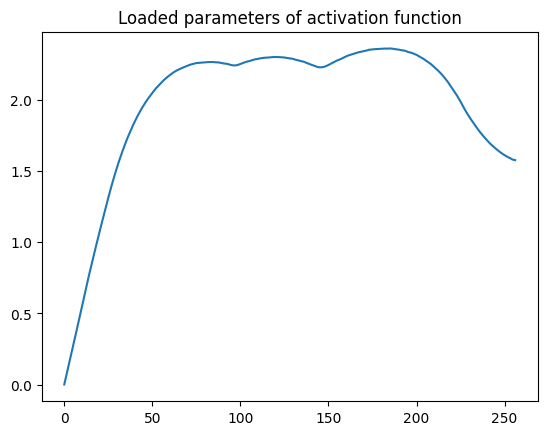

In [11]:
# Loading the model
model = torch.load( model_path + model_file_name )
#model = torch.load(model_file_name)

plt.plot(list(model.parameters())[0].detach())
plt.title("Loaded parameters of activation function")
plt.show()

In [12]:
# Hyperparameters
smooth_rate = 0.005
constrain_rate = 1.0 # F(v=0) = 0
targets_rate = 1 /batch_size

# Define number of epochs
num_epochs = 50

# Define loss function and optimizer
L2_loss = nn.MSELoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=0.45)

running_loss = 0
loss_array = []

#used for graphs
max_i = len(my_dataloader)

# Iterate through epochs
for epoch in range(num_epochs):
    # Iterate through data in the DataLoader
    for i, data in enumerate(my_dataloader, 0):
        # Get inputs and targets from data
        inputs, targets = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model.forward(inputs)

        L2_computed_loss = L2_loss(outputs, targets)
        # Compute loss
        loss = (smooth_rate * smooth_loss(list(model.parameters())[0]) +\
            constrain_rate*physics_constrain(list(model.parameters())[0]) + targets_rate * L2_computed_loss)


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # Print every 100 mini-batches
            print("L2_loss:", L2_computed_loss.detach().item())
            loss_array.append(L2_computed_loss.detach().item())
            print('[Epoch %d, Mini-batch %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    
    if epoch % 100 == 10:
        # saving the model
        torch.save(model, model_path + f"song_0403_epoch{epoch}.pt")
    

# finish training
torch.save(model, model_path + f"song_0403_epoch{epoch}.pt")
print('Finished training')

L2_loss: 33.882102966308594
[Epoch 1, Mini-batch   100] Loss: 0.141
L2_loss: 81.35322570800781
[Epoch 1, Mini-batch   200] Loss: 1.391
L2_loss: 12.558382034301758
[Epoch 1, Mini-batch   300] Loss: 1.248
L2_loss: 24.770721435546875
[Epoch 1, Mini-batch   400] Loss: 0.448
L2_loss: 33.617897033691406
[Epoch 2, Mini-batch   100] Loss: 0.702
L2_loss: 80.88037109375
[Epoch 2, Mini-batch   200] Loss: 1.382
L2_loss: 12.376253128051758
[Epoch 2, Mini-batch   300] Loss: 1.241
L2_loss: 24.504173278808594
[Epoch 2, Mini-batch   400] Loss: 0.443
L2_loss: 33.362613677978516
[Epoch 3, Mini-batch   100] Loss: 0.695
L2_loss: 80.39968872070312
[Epoch 3, Mini-batch   200] Loss: 1.373
L2_loss: 12.196002960205078
[Epoch 3, Mini-batch   300] Loss: 1.234
L2_loss: 24.23971939086914
[Epoch 3, Mini-batch   400] Loss: 0.438
L2_loss: 33.108421325683594
[Epoch 4, Mini-batch   100] Loss: 0.689
L2_loss: 79.98062133789062
[Epoch 4, Mini-batch   200] Loss: 1.365
L2_loss: 12.018351554870605
[Epoch 4, Mini-batch   300] 

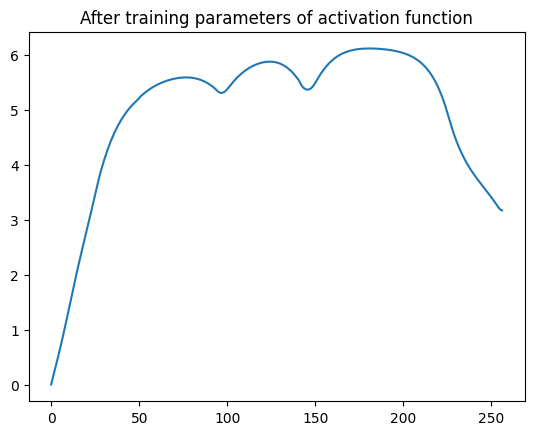

In [13]:
plt.plot(list(model.parameters())[0].detach())
plt.title("After training parameters of activation function")
plt.show()

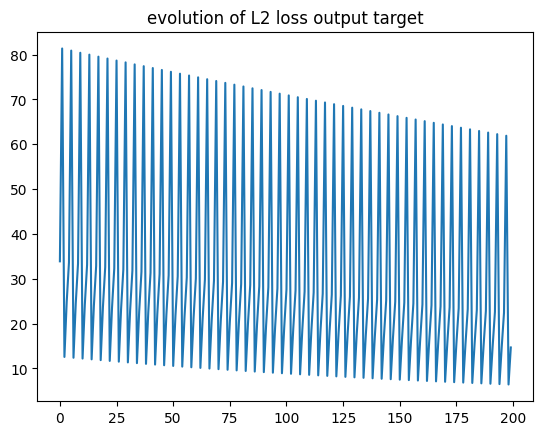

In [15]:
# plot loss
plt.plot(loss_array)
plt.title("evolution of L2 loss output target")
plt.show()

In [ ]:
# saving the model
torch.save(model, f"./song_0403_best3_epoch600_noshuffle.pt")